In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_metric,load_dataset,concatenate_datasets,load_from_disk, Dataset

import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification,AdamW,get_scheduler,TrainingArguments,Trainer


import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm, trange
import nltk

import csv
import gc

checkpoint = 'bert-base-cased'
#checkpoint = 'distilbert-base-uncased'

NEUTRAL = 0
FEMALE = 1
MALE = 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
transformers.logging.set_verbosity(transformers.logging.ERROR)

#### function definitions

In [7]:
def tokenize_function(data):
    return tokenizer(data['text'], truncation=True)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
def compute_metrics(test_dataloader):
    metric = load_metric("f1")

    model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        
    return metric.compute(average='micro')

# Preprocessing

In [4]:
funpedia = load_dataset("md_gender_bias", "funpedia")
wizard = load_dataset("md_gender_bias", "wizard")
image_chat = load_dataset("md_gender_bias","image_chat")

Reusing dataset md_gender_bias (/home/horyctom/.cache/huggingface/datasets/md_gender_bias/funpedia/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224)
Reusing dataset md_gender_bias (/home/horyctom/.cache/huggingface/datasets/md_gender_bias/wizard/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224)
Reusing dataset md_gender_bias (/home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224)


### Image-Chat preprocessing

In [7]:
def clean_text(text):
    return text.replace('<start> a ','').replace('<start> an ','').replace('<start> ','').replace(' <eos>','')

#method for creating new dataset out of existing which is labeled in a way that doesn't fit our other datasets
#mapping male=False female=False -> 0
#        male=False female=True  -> 1
#        male=True  female=False -> 2
def clean_image_chat_data(split:str):
    img_male = image_chat[split].filter(lambda item: item['male'] == True and item['female'] == False)
    img_female = image_chat[split].filter(lambda item: item['male'] == False and item['female'] == True)
    img_neutral = image_chat[split].filter(lambda item: item['male'] == False and item['female'] == False)
    
    labels = [MALE for i in range(img_male.num_rows)] + [FEMALE for i in range(img_female.num_rows)] + [NEUTRAL for i in range(img_neutral.num_rows)]
    texts = [clean_text(t) for t in img_male['caption']] + [clean_text(t) for t in img_female['caption']] + [clean_text(t) for t in img_neutral['caption']]

    dictionary = {'text': texts, 'labels' : labels}
    final = Dataset.from_dict(dictionary,features=train_funpedia.features)
    
    #valid split is too large, let it be smaller for faster processing
    if split == 'validation':
        final = final.shuffle()
        final = final.shard(num_shards=150, index=0)
    
    return final.shuffle()

### Clean and aggregate

In [8]:
train_funpedia = funpedia['train'].remove_columns(['persona','title'])
train_wizard = wizard['train'].remove_columns(['chosen_topic'])
valid_funpedia = funpedia['validation'].remove_columns(['persona','title'])
valid_wizard = wizard['validation'].remove_columns(['chosen_topic'])
test_funpedia = funpedia['test'].remove_columns(['persona','title'])
test_wizard = wizard['test'].remove_columns(['chosen_topic'])

train_funpedia = train_funpedia.rename_column('gender', 'labels')
train_wizard = train_wizard.rename_column('gender', 'labels')
valid_funpedia = valid_funpedia.rename_column('gender', 'labels')
valid_wizard = valid_wizard.rename_column('gender', 'labels')
test_funpedia = test_funpedia.rename_column('gender','labels')
test_wizard = test_wizard.rename_column('gender','labels')


train_image = clean_image_chat_data('train')
valid_image = clean_image_chat_data('validation')
test_image = clean_image_chat_data('test')

Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-d6e6d6310f62b7af.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-f1af33a74176b09b.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-705ea50cffcade4c.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-897168e8cdea99d5.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/image_chat/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cach

In [9]:
train_data = concatenate_datasets([train_funpedia, train_wizard,train_image]).shuffle()
valid_data = concatenate_datasets([valid_funpedia, valid_wizard,valid_image]).shuffle()
test_data = concatenate_datasets([test_funpedia, test_wizard,test_image]).shuffle()

In [27]:
print(train_data)
print(train_data.features)
print(train_data[14])

Dataset({
    features: ['text', 'labels'],
    num_rows: 44104
})
{'text': Value(dtype='string', id=None), 'labels': ClassLabel(num_classes=3, names=['gender-neutral', 'female', 'male'], names_file=None, id=None)}
{'text': 'woman in a pink dress standing in front of a building with a pink and white dress', 'labels': 1}


In [38]:
train_data.to_csv('./train_data.csv')
valid_data.to_csv('./validation_data.csv')
test_data.to_csv('./testing_data.csv')

610304

### Tokenize

In [8]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [31]:
token_train = train_data.map(tokenize_function,batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

token_valid = valid_data.map(tokenize_function,batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

token_test = test_data.map(tokenize_function,batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/45 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [32]:
token_train = token_train.remove_columns(['text'])
token_valid = token_valid.remove_columns(['text'])
token_test = token_test.remove_columns(['text'])

token_train.set_format("torch")
token_valid.set_format("torch")
token_test.set_format("torch")

### Gender stats

In [51]:
def plot_gender():
    labels = ['Male', 'Female', 'Neutral']
    sizes = [no_male,no_female, no_neutral]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/funpedia/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-bad8d95e4b1b749b.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/funpedia/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-0ca72f103ee1694e.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/md_gender_bias/funpedia/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224/cache-07a0f7a88c25889a.arrow


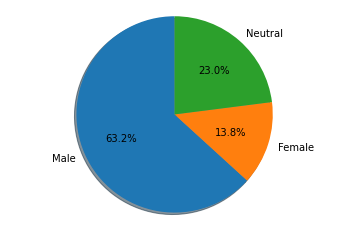

In [52]:
no_neutral = train_data.filter(lambda x : x['labels'] == 0).num_rows
no_female = train_data.filter(lambda x : x['labels'] == 1).num_rows
no_male = train_data.filter(lambda x : x['labels'] == 2).num_rows
plot_gender()

### Create DataLoaders

In [53]:
train_dataloader = DataLoader(
    token_train, shuffle=True, batch_size=64, collate_fn=data_collator)

eval_dataloader = DataLoader(
    token_valid, batch_size=64, collate_fn=data_collator)

test_dataloader = DataLoader(
    token_test, batch_size=64, collate_fn=data_collator)

test_onebatch_dataloader = DataLoader(
    token_test, batch_size=test_data.num_rows, collate_fn=data_collator)

### Sanity check

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [56]:
batch = next(iter(train_dataloader)).to(device)
labels = batch.pop('labels')
outputs = model(**batch)
logits = outputs.logits
weights = torch.tensor([0.6, 0.3, 0.1]).to(device)
loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
loss_fct(logits,labels)

tensor(0.9422, device='cuda:0', grad_fn=<NllLossBackward>)

## Get weights

In [57]:
class_samples = [no_neutral,no_female,no_male]

### Inverse of Number of Samples (INS)

In [58]:
weights_ins = 1.0 / np.array(class_samples)
weights_ins = weights_ins / sum(weights_ins)
weights_ins

array([0.32984034, 0.55025858, 0.11990109])

### Inverse of Square Root of Number of Samples (ISNS)

In [59]:
weights_isns = 1.0 / np.array(np.power(class_samples,0.5))
weights_isns = weights_isns / sum(weights_isns)
weights_isns

array([0.34547919, 0.44622451, 0.2082963 ])

### Effective Number of Samples (ENS)

In [60]:
beta = 0.9999
weight_for_samples = (1.0 - beta) / (1.0 - np.power(beta,class_samples))
weights_ens = weight_for_samples / sum(weight_for_samples)
weights_ens

array([0.32488167, 0.45454932, 0.220569  ])

In [61]:
weights = torch.tensor([weights_ins,weights_isns,weights_ens]).float().to(device)
weights

tensor([[0.3298, 0.5503, 0.1199],
        [0.3455, 0.4462, 0.2083],
        [0.3249, 0.4545, 0.2206]], device='cuda:0')

## Training

In [65]:
class WeightedTrainer(Trainer):
    def __init__(self,weights, *args, **kwargs):
        super(WeightedTrainer, self).__init__(*args, **kwargs)
        self.weights = torch.tensor(weights).to(device)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights)
        loss = loss_fct(logits,labels)
        return (loss, outputs) if return_outputs else loss

In [63]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [66]:
training_args = TrainingArguments(
    output_dir='../',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=64, # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate  
    save_steps=5000,
    disable_tqdm = False,
    save_total_limit=2,
    weight_decay=0.01)               # strength of weight decay

trainer = WeightedTrainer(
    weights[0],
    model,
    training_args,
    train_dataset=token_train,
    eval_dataset=token_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_15166/40293319.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights).to(device)


In [67]:
trainer.train()

***** Running training *****
  Num examples = 44104
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3450


Step,Training Loss
500,0.393900
1000,0.258600
1500,0.198800
2000,0.120800
2500,0.063600
3000,0.043700




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3450, training_loss=0.15970300978508548, metrics={'train_runtime': 618.1213, 'train_samples_per_second': 356.758, 'train_steps_per_second': 5.581, 'total_flos': 4939703637866928.0, 'train_loss': 0.15970300978508548, 'epoch': 5.0})

### Evaluate

In [75]:
metric = load_metric("f1")

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    
metric.compute(average='macro')

{'f1': 0.9334442346570441}

In [71]:
batch = next(iter(test_onebatch_dataloader))

model.eval()
with torch.no_grad():
    batch.to(device)
    output = model(**batch)

labels = torch.tensor(test_data['labels'])
preds = F.softmax(output.logits,dim=1).argmax(dim=1)

Confusion matrix, without normalization
[[3742   17  130]
 [   5  716   95]
 [  76   75 3436]]


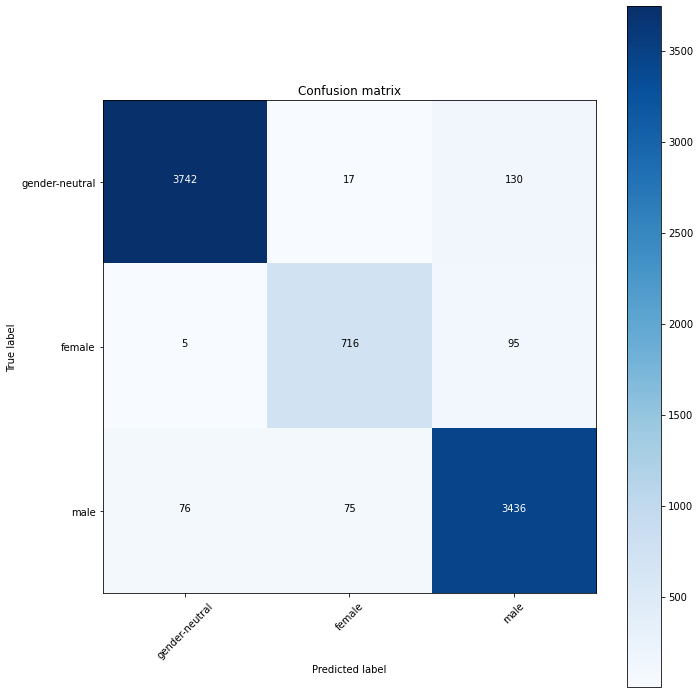

In [73]:
cm = confusion_matrix(labels,preds.cpu())

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,test_data.features['labels'].names)

In [90]:
fp = open("../data/michelle_obama.txt")
data = fp.read()

tokenizer_text = nltk.data.load('tokenizers/punkt/english.pickle')

inputs = tokenizer_text.tokenize(data)

inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    inputs.to(device)
    output = model(**inputs)
    
classification = F.softmax(output.logits,dim=1).argmax(dim=1)
classification

tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [100]:
torch.mean(classification.to(torch.float))

tensor(1.1250, device='cuda:0')